# MedSync Baseline Modelling for all products

In [35]:
import sys
import warnings
import re

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_error,
    d2_tweedie_score,
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

DATA_PATH = "../data"

In [36]:
# Load excel file
df = pd.read_excel(DATA_PATH + "/consumo_material_clean.xlsx")

# Preprocessing

In [37]:
# Separate code into two columns
new_columns = df["P_code"].str.extract(r"([a-zA-Z]+)([0-9]+)", expand=False)
df["P_code_CLASS"] = new_columns[0]
df["P_code_NUM"] = new_columns[1]
df.drop(columns=["P_code"], inplace=True)

In [38]:
# P_date to datetime in day/month/year format
df["P_date"] = pd.to_datetime(df["P_date"], dayfirst=True)
df.sort_values(by=["P_date"], inplace=True)
df.reset_index(drop=True, inplace=True)

C:\Users\AMAR2\AppData\Local\Temp\ipykernel_26328\3581088518.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["P_date"] = pd.to_datetime(df["P_date"], dayfirst=True)


In [39]:
# assert all rows in H_code follow number-number-number format
def fix_origen_typos(origen_string):
    numbers = re.findall(r"[0-9]+", origen_string)
    return "-".join(numbers)


df["H_code"] = df["H_code"].apply(fix_origen_typos)

In [40]:
# separate H_code in three columns by '-'
origin_separated_columns = df["H_code"].str.split("-", expand=True)
df["PURCHASING_REGION"] = origin_separated_columns[0]
df["PURCHASING_HOSPITAL"] = origin_separated_columns[1]
df["PURCHASING_DEPARTMENT"] = origin_separated_columns[2]
df.drop(columns=["H_code"], inplace=True)

In [41]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [42]:
# basic date features
def generate_date_features(df):
    df["YEAR"] = df["P_date"].dt.year
    df["MONTH"] = np.sin(2 * np.pi * df["P_date"].dt.month / 12)
    df["DAYOFMONTH"] = np.sin(2 * np.pi * df["P_date"].dt.day / 31)
    df["DAYOFYEAR"] = np.sin(2 * np.pi * df["P_date"].dt.dayofyear / 365)
    return df

In [43]:
def add_timeseries_features(df):
    df["ROLLING_MEAN_3M"] = df["N_product_purchased"].rolling(90).mean()
    df["WEIGHTED_MEAN_3M"] = (
        df["N_product_purchased"]
        .rolling(90)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    df["EWMA_3M"] = df["N_product_purchased"].ewm(span=90).mean()
    df["ROLLING_MEAN_1Y"] = df["N_product_purchased"].rolling(365).mean()
    df["WEIGHTED_MEAN_1Y"] = (
        df["N_product_purchased"]
        .rolling(365)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    df["EWMA_1Y"] = df["N_product_purchased"].ewm(span=365).mean()
    # average N_product_purchased over year
    df["AVG_1Y"] = df.groupby(["YEAR"])["N_product_purchased"].transform("mean")
    df["AVG_1Y"] = df["AVG_1Y"].fillna(df["AVG_1Y"].mean())
    return df

In [44]:
# get pairings of product and hospital and create a dict "product number": list of hospitals
pairings = df.groupby(["P_code_NUM", "PURCHASING_HOSPITAL"]).size().reset_index()
pairings = pairings.groupby(["PURCHASING_HOSPITAL"])["P_code_NUM"].apply(list)
pairings = pairings.to_dict()

In [45]:
def generate_train_test_df(full_df):
    # Get train and test sets
    train = full_df[full_df["YEAR"] < 2023]
    X_train = train.drop(columns=["N_product_purchased", "P_date"])
    y_train = train["N_product_purchased"]

    test = full_df[full_df["YEAR"] == 2023]
    X_test = test.drop(columns=["N_product_purchased", "P_date"])
    y_test = test["N_product_purchased"]

    return train, X_train, y_train, test, X_test, y_test

In [46]:
def smape_score(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [47]:
def train_model_eval(X_train, y_train, X_test, y_test):
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test)
    y_test_pred = y_test_pred

    test_loss = mean_squared_error(y_test, y_test_pred, squared=False)
    mape_error = mean_absolute_percentage_error(y_test, y_test_pred)
    tweedie = d2_tweedie_score(y_test, y_test_pred)
    smape_err = smape_score(y_test, y_test_pred)

    return test_loss, mape_error, smape_err, tweedie

In [48]:
def plot_model_predictions(full_df, product, hospital, plot_train=False):
    columns = ["P_date", "N_product_purchased"]
    partial_df = full_df.loc[
        (full_df["PURCHASING_HOSPITAL"] == hospital)
        & (full_df["P_code_NUM"] == product)
    ][columns]
    partial_df = generate_date_features(partial_df)
    partial_df = add_timeseries_features(partial_df)
    train, X_train, y_train, test, X_test, y_test = generate_train_test_df(partial_df)

    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    X_train["PREDICTION"] = model.predict(X_train)
    X_train["REAL"] = y_train
    X_train["P_date"] = train["P_date"]

    X_test["PREDICTION"] = model.predict(X_test)
    X_test["REAL"] = y_test
    X_test["P_date"] = test["P_date"]

    plt.figure(figsize=(30, 10))
    if plot_train:
        sns.lineplot(
            x="P_date",
            y="PREDICTION",
            data=X_train,
            marker="o",
            label="train preds",
        )
        sns.lineplot(
            x="P_date", y="REAL", data=X_train, marker="o", label="train real"
        )

    sns.lineplot(
        x="P_date", y="PREDICTION", data=X_test, marker="o", label="test preds"
    )
    sns.lineplot(x="P_date", y="REAL", data=X_test, marker="o", label="test real")

    plt.legend()
    plt.show()

In [49]:
%%time

# iterate over each hospital and list of products
columns = ["P_date", "N_product_purchased"]

product_hospital_losses = pd.DataFrame(columns=["PRODUCT", "HOSPITAL", "Tweedie", "MSE", "SMAPE"])
for hospital, product_list in pairings.items():
    for product in product_list:
        partial_df = df.loc[
            (df["PURCHASING_HOSPITAL"] == hospital) & (df["P_code_NUM"] == product)
        ][columns]
        partial_df = generate_date_features(partial_df)
        partial_df = add_timeseries_features(partial_df)

        is_2023_in_df = 2023 in partial_df["YEAR"].unique()
        is_only_1_year = partial_df["YEAR"].nunique() == 1
        has_few_samples = partial_df[partial_df["YEAR"] == 2023].shape[0] < 5

        if not is_2023_in_df or is_only_1_year or has_few_samples:
            continue

        train, X_train, y_train, test, X_test, y_test = generate_train_test_df(
            partial_df
        )
        test_loss, mape_error, smape, tweedie = train_model_eval(X_train, y_train, X_test, y_test)

        product_hospital_losses = pd.concat(
            [
                product_hospital_losses,
                pd.DataFrame(
                    [[product, hospital, tweedie, test_loss, smape]],
                    columns=["PRODUCT", "HOSPITAL", "Tweedie", "MSE", "SMAPE"],
                ),
            ]
        )

CPU times: total: 1min 7s
Wall time: 11.9 s


In [50]:
product_hospital_losses.sort_values(by=["MSE"], ascending=False).head(20)

,PRODUCT,HOSPITAL,Tweedie,MSE,SMAPE
0,66071,7,-0.666667,2162.997920,72.380952
0,66071,13,-0.497128,1203.694808,56.022361
0,64911,7,-0.250000,402.492236,24.000000
0,64764,18,-0.593710,395.813117,10.232688
0,64751,0,-0.012588,332.793997,11.643866
0,64663,13,-21.843049,286.766413,43.321986
0,64764,10,-1.617280,286.167404,31.231760
0,64765,0,-0.624390,285.491504,24.454642
0,64663,10,-55.554562,273.900270,43.105927
0,64765,18,0.105058,211.907019,8.016129


In [51]:
product_hospital_losses.groupby(["PRODUCT"])["MSE"].mean().sort_values(
    ascending=False
).head(20)

PRODUCT
66071    878.103531
64764    294.385180
64911    249.398010
64765    248.699262
64751    246.592066
64663    161.244877
73753    148.923692
65056    136.286357
64940     99.461768
64488     97.927799
85758     84.675259
64932     75.282179
64983     64.848522
65894     61.383407
65509     60.735506
65486     58.685913
85769     58.262541
64544     33.207605
70130     31.863797
41691     29.812472
Name: MSE, dtype: float64

In [52]:
product_hospital_losses[product_hospital_losses["Tweedie"] != -np.inf]["Tweedie"].mean()

-5.742496289883125

In [53]:
product_hospital_losses["MSE"].mean()

92.90490707062995

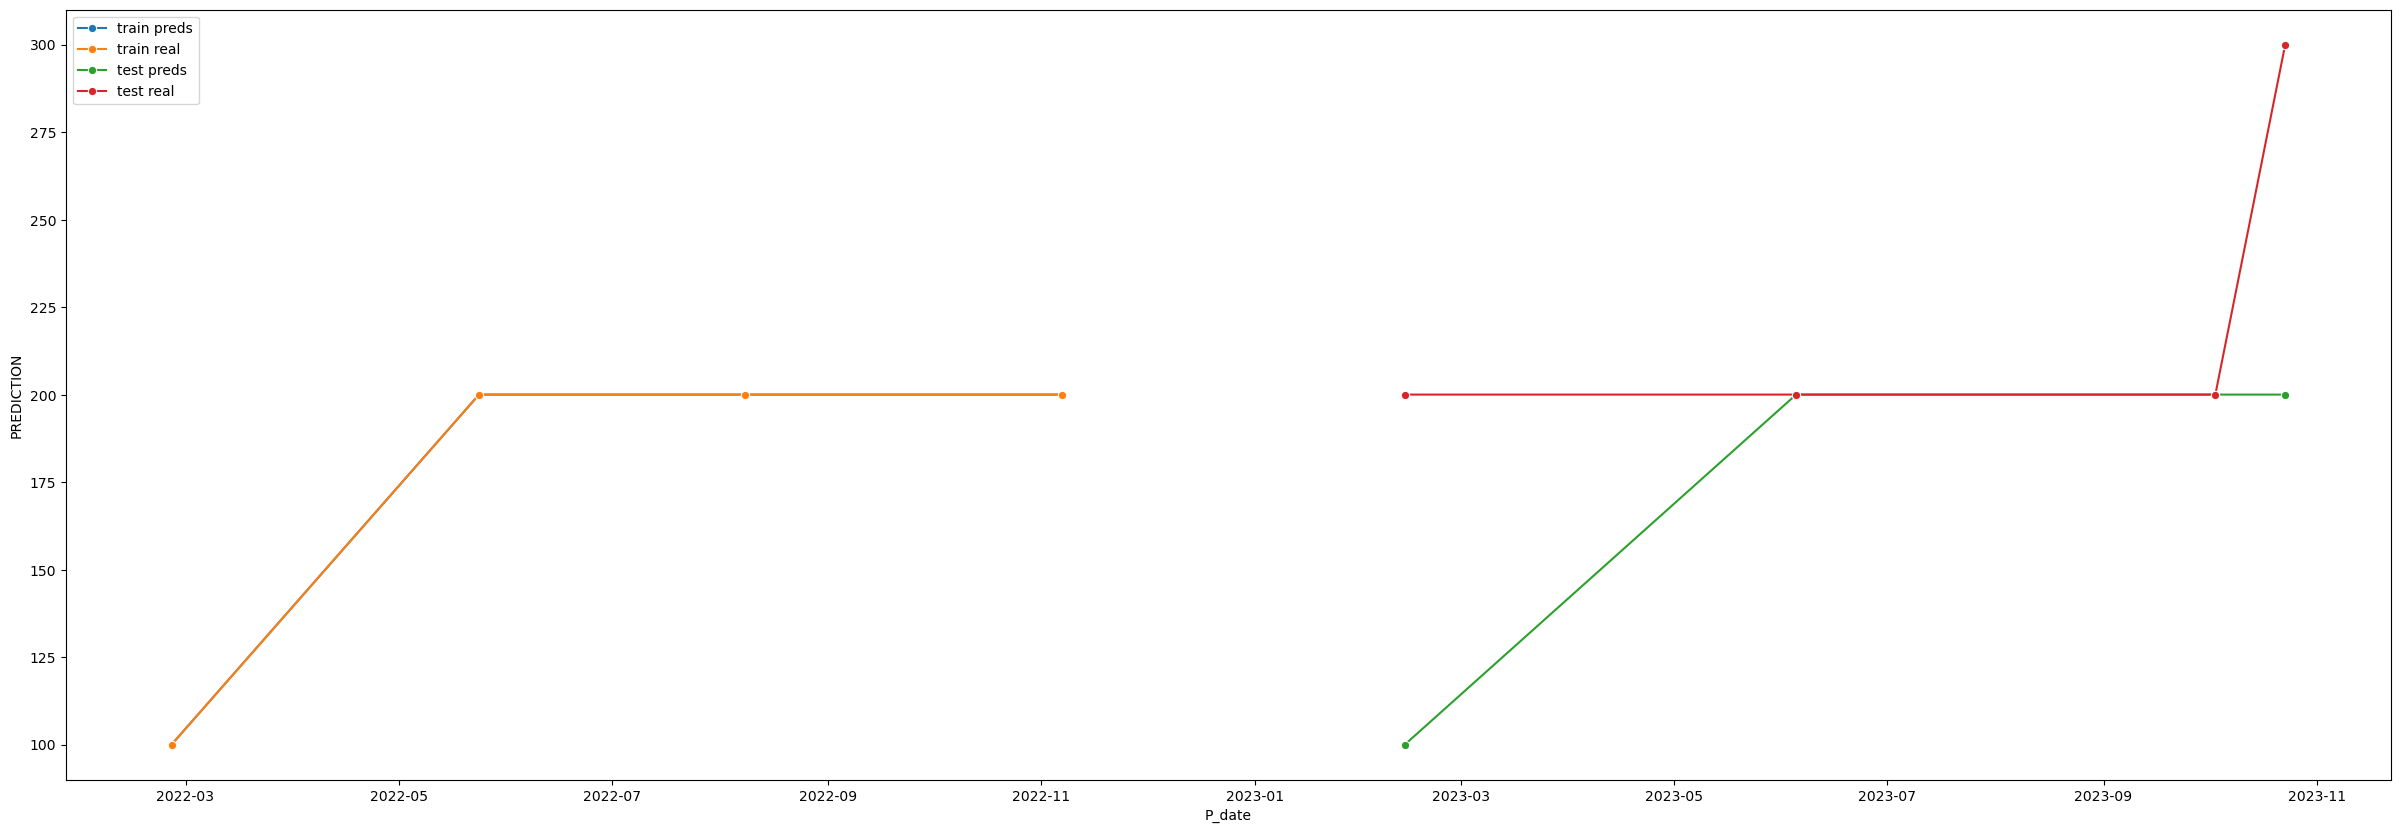

In [67]:
plot_model_predictions(full_df=df, product="65509", hospital="7", plot_train=True)

In [56]:
import pickle
filename="../savmodel.sav"
pickle.dump(plot_model_predictions, open(filename, 'wb'))

In [65]:
load_model=pickle.load(open(filename, 'rb'))